<Axes: xlabel='k', ylabel='discrepancy'>

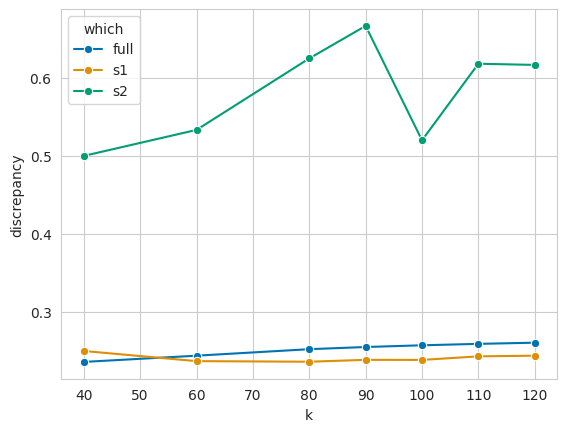

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D
import numpy as np

sns.set_palette("colorblind")
sns.set_style("whitegrid")


df = pd.read_csv("run-data/info.csv")

sns.lineplot(data=df, x="k", y="discrepancy", hue="which", marker="o")

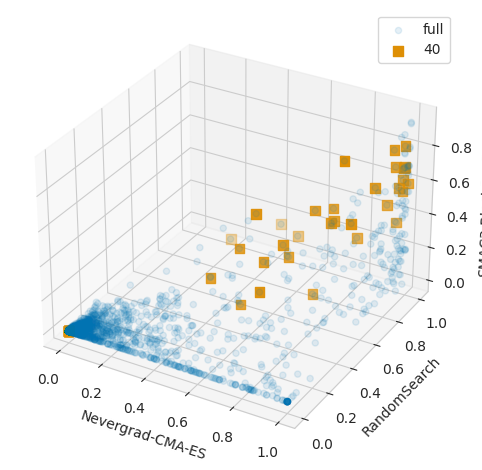

In [2]:
full_set = pd.read_csv("run-data/df_crit.csv", index_col="problem_id")
axes_labels = list(full_set.columns)
subset_paths = list(Path("run-data").glob("subset*"))
subset_paths.sort()
ks = np.array([int(p.name.split(".")[0].split("_")[1]) for p in subset_paths])
ids = np.argsort(ks)
subset_paths = np.array(subset_paths)[ids]
ks = ks[ids]
subsets = [pd.read_csv(p, index_col="problem_id") for p in subset_paths]

markers = list(Line2D.markers.keys())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

points = full_set.to_numpy()
ax.scatter(points[:,0], points[:,1], points[:,2], label="full", alpha=0.1)

for i, subset in enumerate(subsets):
    points = subset.to_numpy()
    if ks[i] == 40 or False:
        ax.scatter(points[:,0], points[:,1], points[:,2], label=ks[i], marker=markers[i+1], s=50)

ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])

# ax.view_init(30,45)


ax.legend()

fig.set_tight_layout(True)

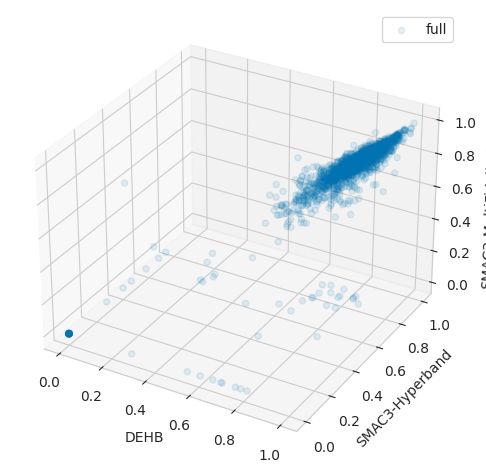

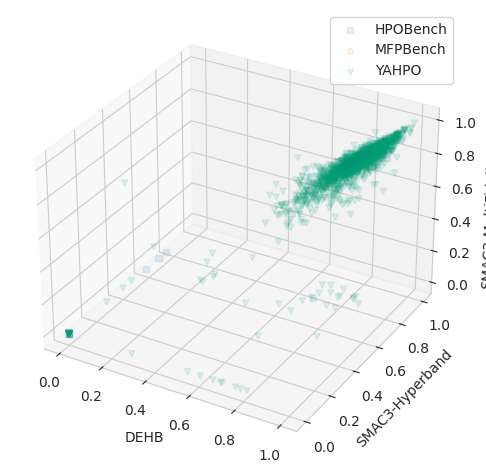

In [12]:
# Plot df_crit
filename = "../MF_df_crit.parquet"
full_set = pd.read_parquet(filename)
axes_labels = list(full_set.columns)

full_set = full_set.map(lambda x: np.log10(x+1e-10))  # avoid inf
def norm(x: pd.Series) -> pd.Series:
    return (x - x.min()) / (x.max() - x.min())
full_set = full_set.transform(norm)
full_set.to_csv("MF_df_crit_log_norm.csv")

def add_benchmark_id(x: pd.Series) -> pd.Series:
    problem_ids = x.to_numpy()
    def which_benchmark(problem_id: str):
        if problem_id.startswith("bbob"):
            return "BBOB"
        elif problem_id.startswith("hpobench"):
            return "HPOBench"
        elif problem_id.startswith("hpob"):
            return "HPOB"
        elif problem_id.startswith("yahpo"):
                return "YAHPO"
        elif problem_id.startswith("mfpbench"):
                return "MFPBench"
        else:
             raise ValueError(f"Unknown problem_id {problem_id}")
    benchmark_ids = [which_benchmark(p) for p in problem_ids]
    return benchmark_ids

full_set["benchmark_id"] = add_benchmark_id(full_set.index)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
points = full_set.to_numpy()
ax.scatter(points[:,0], points[:,1], points[:,2], label="full", alpha=0.1)
ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])
ax.legend()
fig.set_tight_layout(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, (gid, gdf) in enumerate(full_set.groupby("benchmark_id")):
    points = gdf.to_numpy()
    ax.scatter(points[:,0], points[:,1], points[:,2], label=str(gid), alpha=0.1, marker=markers[i+1])
ax.set_xlabel(axes_labels[0])
ax.set_ylabel(axes_labels[1])
ax.set_zlabel(axes_labels[2])
ax.legend()
fig.set_tight_layout(True)
plt.show()

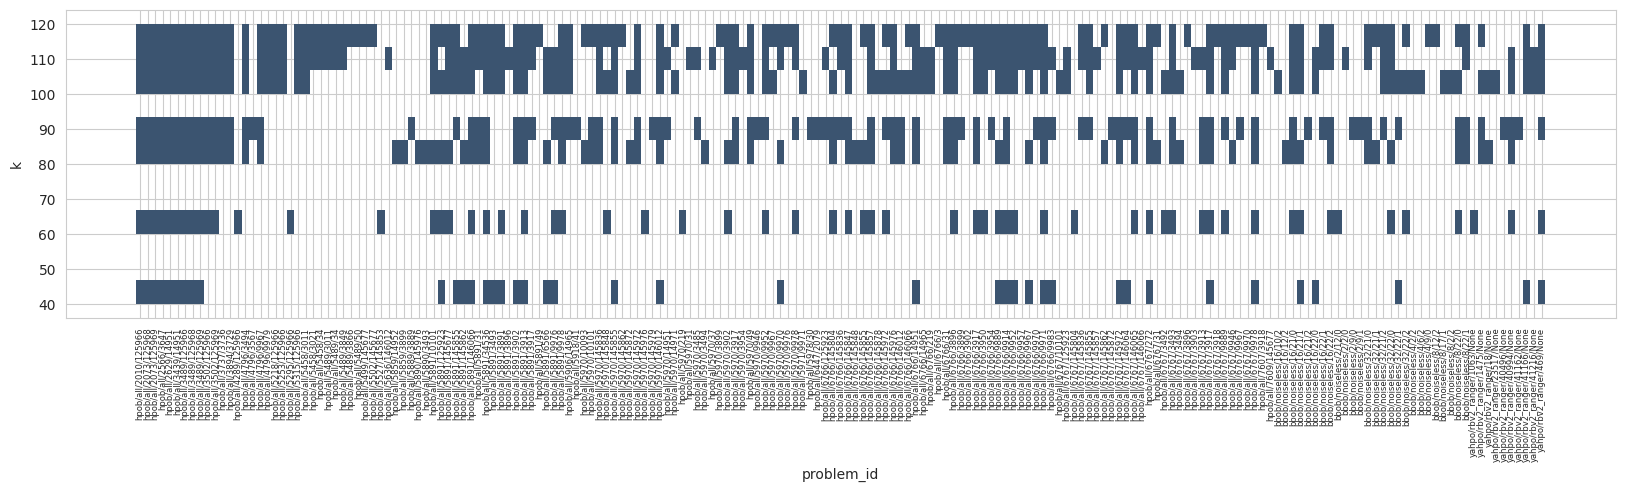

ValueError: Could not interpret value `task.dimensions` for `x`. An entry with this name does not appear in `data`.

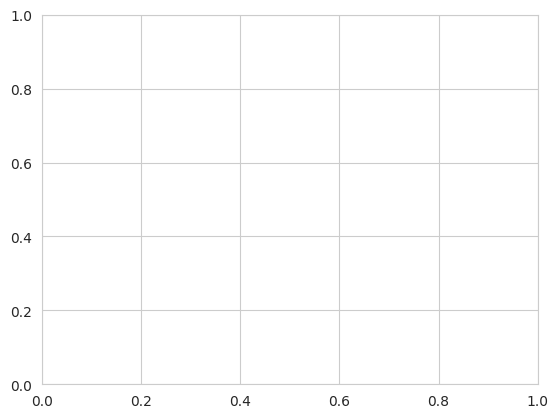

In [4]:
from carps.analysis.gather_data import maybe_postadd_task




# def add_metadata(selected_problems: pd.DataFrame) -> pd.DataFrame:


selected_problems = pd.concat([pd.DataFrame({
    "problem_id": list(subsets[i].index),
    "k": [ks[i]] * len(list(subsets[i].index))
}) for i in range(len(subsets))])
selected_problems = selected_problems.sort_values(by="problem_id")
selected_problems = maybe_postadd_task(selected_problems)
selected_problems["problem_id"] = selected_problems["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
selected_problems["benchmark_id"] = selected_problems["problem_id"].apply(lambda x: x.split("/")[0])

fig, ax = plt.subplots(figsize=(20,4))
ax = sns.histplot(data=selected_problems, x="problem_id", y="k", ax=ax)
ax.tick_params(axis="x", rotation=90, labelsize=6)
plt.show()

selected_k = 40

fig, ax = plt.subplots()
ax = sns.histplot(data=selected_problems[selected_problems["k"]==selected_k], x="task.dimensions", bins=selected_k//2)
plt.show()

fig, ax = plt.subplots()
ax = sns.histplot(data=selected_problems[selected_problems["k"]==selected_k], x="benchmark_id")
plt.show()



In [ ]:
selected_problems.columns

Index(['problem_id', 'k', 'task.n_trials', 'task.time_budget',
       'task.n_workers', 'task.n_objectives', 'task.objectives',
       'task.is_multifidelity', 'task.fidelity_type', 'task.min_budget',
       'task.max_budget', 'task.has_constraints', 'task.domain',
       'task.objective_function_approximation', 'task.has_virtual_time',
       'task.deterministic', 'task.dimensions',
       'task.search_space_n_categoricals', 'task.search_space_n_ordinals',
       'task.search_space_n_integers', 'task.search_space_n_floats',
       'task.search_space_has_conditionals',
       'task.search_space_has_forbiddens', 'task.search_space_has_priors'],
      dtype='object')